In [191]:
DEBUG = False
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import pydicom
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import resize

from monai.transforms import Resize
import  monai.transforms as transforms

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

In [12]:
sys.path = [
    'D:/Deep_Learning_for_3D_Image_Segmentation/myenv/Lib/site-packages/conv3d_same.py',
] + sys.path

from timm.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame
from typing import Any, Dict, Optional

Config

In [139]:
kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'resnet18d'

image_sizes = [128,128,128] #size of Unet
R = Resize(image_sizes)

init_lr = 3e-3
batch_size = 4
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = 'D:\\Deep_Learning_for_3D_Image_Segmentation'
use_amp = True
num_workers = 0 #4
out_dim = 7

n_epochs = 1000
log_dir = 'D:/Deep_Learning_for_3D_Image_Segmentation/logs_koln'
model_dir = 'D:/Deep_Learning_for_3D_Image_Segmentation/models_koln'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [14]:
transforms_train = transforms.Compose([
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
    transforms.RandAffined(keys=["image", "mask"], translate_range=[int(x*y) for x, y in zip(image_sizes, [0.3, 0.3, 0.3])], padding_mode='zeros', prob=0.7),
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest"),    
])

transforms_valid = transforms.Compose([
])

In [135]:
df_train = pd.read_csv(os.path.join(data_dir, 'train_koln.csv'))
df_train.head()
mask_files = os.listdir(os.path.join(data_dir, 'Masks'))
df_mask = pd.DataFrame({
    'mask_file': sorted(mask_files)
})
df_mask = df_mask[0:] 
df_mask = df_mask.reset_index(drop = True)
df_mask['Folder Names'] = df_mask['mask_file'].apply(lambda x: x[:-5])
df_mask['mask_file'] = df_mask['mask_file'].apply(lambda x: os.path.join(data_dir,'Masks',x))
df = df_train.merge(df_mask, on = 'Folder Names', how = 'left')
df.head()
df['image_folder'] = df['Folder Names'].apply(lambda x: os.path.join(data_dir, 'Deidentified_Scans', x+'_1'))
df['mask_file'].fillna('', inplace = True)
df.rename(columns = {'Folder Names' : 'FolderNames'}, inplace = True)
df_seg = df.query('mask_file !=""').reset_index(drop=True)

kf = KFold(5)
df_seg['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_seg, df_seg)):
    df_seg.loc[valid_idx, 'fold'] = fold

df_seg

,FolderNames,Study Instance UID,PelvicBone,RightFemur,RightPatella,RightTibia,RightFibula,RightTarsalBones,LeftFemur,LeftPatella,LeftTibia,LeftFibula,LeftTarsalBones,mask_file,image_folder,fold
0,CT01,1.2.826.0.1.3680043.8.498.12127160855395570886...,1,1,0,0,0,0,1,0,0,0,0,D:\Deep_Learning_for_3D_Image_Segmentation\Mas...,D:\Deep_Learning_for_3D_Image_Segmentation\Dei...,0
1,CT02,1.2.826.0.1.3680043.8.498.11835843411445491282...,1,1,0,0,0,0,1,0,0,0,0,D:\Deep_Learning_for_3D_Image_Segmentation\Mas...,D:\Deep_Learning_for_3D_Image_Segmentation\Dei...,0
2,CT03,1.2.826.0.1.3680043.8.498.11405534406699440362...,0,1,1,1,1,1,1,1,1,1,1,D:\Deep_Learning_for_3D_Image_Segmentation\Mas...,D:\Deep_Learning_for_3D_Image_Segmentation\Dei...,0
3,CT04,1.2.826.0.1.3680043.8.498.59983503456734602385...,0,1,1,1,1,0,1,1,1,1,0,D:\Deep_Learning_for_3D_Image_Segmentation\Mas...,D:\Deep_Learning_for_3D_Image_Segmentation\Dei...,0
4,CT05,1.2.826.0.1.3680043.8.498.44603202544096487726...,1,1,0,0,0,0,1,0,0,0,0,D:\Deep_Learning_for_3D_Image_Segmentation\Mas...,D:\Deep_Learning_for_3D_Image_Segmentation\Dei...,0
5,CT06,1.2.826.0.1.3680043.8.498.12749575904260714226...,1,1,0,0,0,0,1,0,0,0,0,D:\Deep_Learning_for_3D_Image_Segmentation\Mas...,D:\Deep_Learning_for_3D_Image_Segmentation\Dei...,0
6,CT07,1.2.826.0.1.3680043.8.498.11778113564991067149...,0,1,1,1,1,0,1,1,1,1,0,D:\Deep_Learning_for_3D_Image_Segmentation\Mas...,D:\Deep_Learning_for_3D_Image_Segmentation\Dei...,0
7,CT08,1.2.826.0.1.3680043.8.498.73020308849640490288...,1,1,0,0,0,0,1,0,0,0,0,D:\Deep_Learning_for_3D_Image_Segmentation\Mas...,D:\Deep_Learning_for_3D_Image_Segmentation\Dei...,0
8,CT09,1.2.826.0.1.3680043.8.498.65607736306871182360...,1,1,1,1,1,0,1,1,1,1,0,D:\Deep_Learning_for_3D_Image_Segmentation\Mas...,D:\Deep_Learning_for_3D_Image_Segmentation\Dei...,0
9,CT10,1.2.826.0.1.3680043.8.498.12352214144340680351...,1,1,0,0,0,0,1,0,0,0,0,D:\Deep_Learning_for_3D_Image_Segmentation\Mas...,D:\Deep_Learning_for_3D_Image_Segmentation\Dei...,0


Output df

In [6]:
df.to_csv('output.csv', index=False)

DataFrame

Dataset

In [7]:
revert_list = [
    'CT01',
    'CT02',
    'CT03',
    'CT04',
    'CT05'
]

SEGDataset

In [118]:
class SEGDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        ##GET IMAGES##
        path = self.df.iloc[index]['image_folder']
        path = path.replace('\\','/') + '/*'
        #print(path)
        filepaths = glob(path)
        files = [pydicom.dcmread(fp) for fp in filepaths]
        #print(f"File count: {len(files)}")

        ##GET MASKS##
        maskpath = self.df.iloc[index]['mask_file']
        maskpath = maskpath.replace('\\','/') + '/*'
        #print(maskpath)
        maskfilepaths = glob(maskpath)
        maskfiles = [pydicom.dcmread(fp) for fp in maskfilepaths]
        #print(f"File count: {len(maskfiles)}")

        ##SORT IMAGES##
        slices = []
        skipcount = 0
        for f in files:
            if hasattr(f, 'SliceLocation'):
                slices.append(f)
            else:
                skipcount = skipcount + 1
        slices = sorted(slices, key=lambda s: s.SliceLocation)
        try:
                slice_thickness = abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
        except:
                slice_thickness = abs(slices[0].SliceLocation - slices[1].SliceLocation)
        for s in slices:
                s.SliceThickness = slice_thickness
        slices = sorted(slices, key=lambda s: s.SliceLocation)
        
        # for i in slices:
        #     print('Image SliceLocation '+ str(i.SliceLocation))
        
        print(f"Slices count: {len(slices)}")
        images = np.stack([cv2.resize(s.pixel_array, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR) for s in slices],-1)
        images = images - np.min(images)
        images = images / (np.max(images) + 1e-4)
        images = (images * 255).astype(np.uint8)
        
        if images.ndim < 4:
            image = np.expand_dims(images, 0).repeat(3, 0)

        ##SORT MASKS##
        maskslices = []
        skipcount1 = 0
        for f in maskfiles:
            if hasattr(f, 'InstanceNumber'):
                maskslices.append(f)
            else:
                skipcount1 = skipcount1 + 1
        maskslices = sorted(maskslices, key=lambda s: s.InstanceNumber)
        
        # for i in maskslices:
        #     print('Mask InstanceNumber '+ str(i.InstanceNumber))
        
        print(f"Mask Slices count: {len(maskslices)}")
        masks = np.stack([cv2.resize(s.pixel_array, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR) for s in maskslices],-1)
        mask_org = masks
        shape = mask_org.shape
        
        # mask_org = mask_org.transpose(1, 0, 2)[::-1, :, ::-1]   # (d, w, h)
        mask = np.zeros((3, shape[0], shape[1], shape[2]))
        for cid in range(3):
            mask[cid] = (mask_org == (cid+1))
        mask = mask.astype(np.uint8) * 255
        # mask = R(mask).numpy()
        
        res = self.transform({'image':image, 'mask':mask})
        image = res['image'] / 255.
        mask = res['mask'].astype(np.float32)
        mask = (mask > 127).astype(np.float32)
        image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
        
        print(image.shape)
        print(mask.shape)

        # count = 0
        # for i in range(len(slices)):
        #         if int(slices[i].InstanceNumber) == int(int(maskslices[i].InstanceNumber) + 1):
        #             slice = (slices[i].InstanceNumber)
        #             #print(count)
        #             count += 1
        #             if count == 10:
        #                 break
                    
        # return slices, image, mask
        return image, mask

In [136]:
rcParams['figure.figsize'] = 20,8

df_show = df_seg
dataset_show = SEGDataset(df_show, 'train', transform=transforms_train)

Slices count: 609
Mask Slices count: 609


C:\Users\rache\AppData\Local\Temp\ipykernel_39740\3982410602.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()


torch.Size([3, 128, 128, 609])
torch.Size([3, 128, 128, 609])
Slices count: 641
Mask Slices count: 641
torch.Size([3, 128, 128, 641])
torch.Size([3, 128, 128, 641])
Slices count: 905
Mask Slices count: 905
torch.Size([3, 128, 128, 905])
torch.Size([3, 128, 128, 905])
Slices count: 761
Mask Slices count: 761
torch.Size([3, 128, 128, 761])
torch.Size([3, 128, 128, 761])
Slices count: 641
Mask Slices count: 641
torch.Size([3, 128, 128, 641])
torch.Size([3, 128, 128, 641])
Slices count: 585
Mask Slices count: 585
torch.Size([3, 128, 128, 585])
torch.Size([3, 128, 128, 585])
Slices count: 753
Mask Slices count: 753
torch.Size([3, 128, 128, 753])
torch.Size([3, 128, 128, 753])
Slices count: 681
Mask Slices count: 681
torch.Size([3, 128, 128, 681])
torch.Size([3, 128, 128, 681])


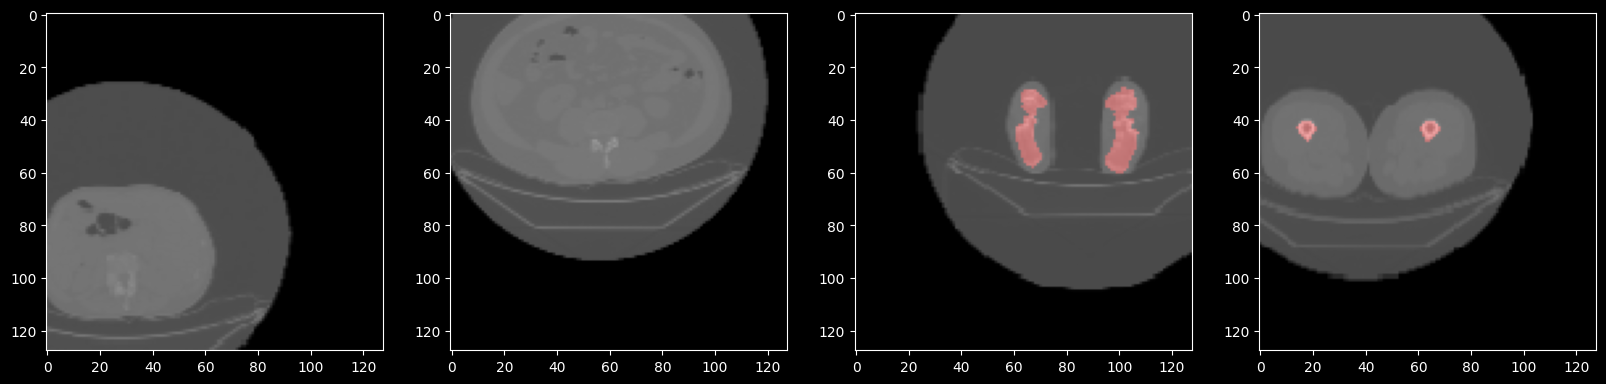

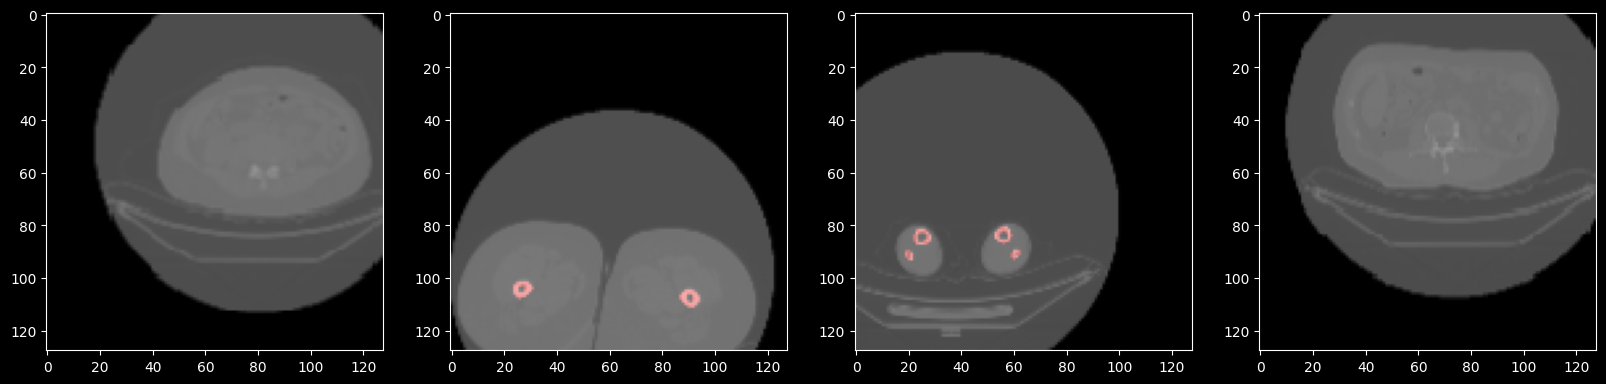

In [124]:
for i in range(2):
    f, axarr = plt.subplots(1,4)
    for p in range(4):
        idx = i*4+p
        img, mask = dataset_show[idx]
        img = img[:, :, :, 50] 
        mask = mask[:, :, :, 50]
        # mask[0] = mask[0] + mask[3] + mask[6]
        # mask[1] = mask[1] + mask[4]
        # mask[2] = mask[2] + mask[5]
        # mask = mask[:3]
        img = img * 0.7 + mask * 0.3 
        axarr[p].imshow(img.transpose(0, 1).transpose(1, 2).squeeze())

Model

In [125]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 3, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [126]:
from timm.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
        kernel_size=module.kernel_size,
        stride=module.stride,
        padding=module.padding,
        dilation=module.dilation,
        ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


m = TimmSegModel(backbone)
m = convert_3d(m)
m(torch.rand(1, 3, 128,128,128)).shape

torch.Size([1, 7, 128, 128, 128])

Loss & Metric

In [127]:
from typing import Any, Dict, Optional


def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score

def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

Train & Valid Function

In [256]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        images = images.cpu()
        gt_masks = gt_masks.cpu()

        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
            if do_mixup:
                loss2 = criterion(logits, gt_masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    batch_metrics = [[]] * 7
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cpu()
            gt_masks = gt_masks.cpu()

            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                pred = (logits.sigmoid() > th).float().detach()
                for i in range(logits.shape[0]):
                    tmp = multilabel_dice_score(
                        y_pred=logits[i].sigmoid().cpu(),
                        y_true=gt_masks[i].cpu(),
                        threshold=0.5,
                    )
                    batch_metrics[thi].extend(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')

    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))

    return np.mean(valid_loss), np.max(metrics)

d:\Deep_Learning_for_3D_Image_Segmentation\myenv\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
d:\Deep_Learning_for_3D_Image_Segmentation\myenv\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if yo

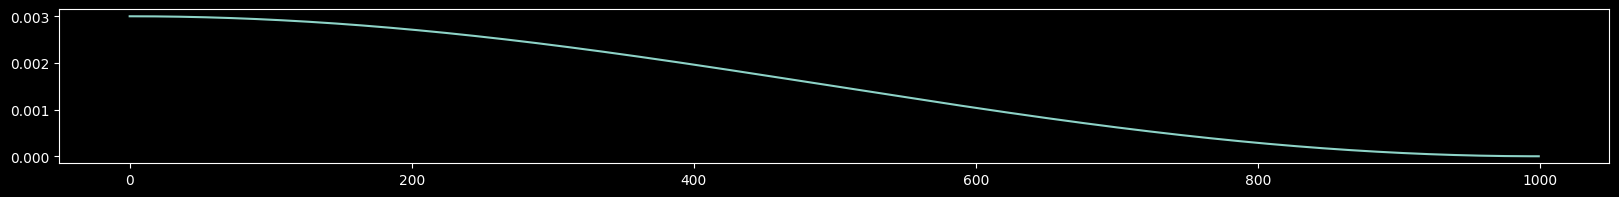

In [251]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
lrs = []
for epoch in range(1, 1000+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

Train

In [252]:
def run(fold):
    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    device = torch.device("cpu")  # Set the device to CPU
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer)
        valid_loss, metric = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [142]:
run(0)
# run(1)
# run(2)
# run(3)
# run(4)

40 10
Tue Jul 11 11:59:53 2023 Epoch: 1


  0%|          | 0/10 [00:00<?, ?it/s]

Slices count: 673
Mask Slices count: 673


C:\Users\rache\AppData\Local\Temp\ipykernel_39740\3982410602.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()


torch.Size([3, 128, 128, 673])
torch.Size([3, 128, 128, 673])
Slices count: 1057
Mask Slices count: 1057
torch.Size([3, 128, 128, 1057])
torch.Size([3, 128, 128, 1057])
Slices count: 505
Mask Slices count: 505
torch.Size([3, 128, 128, 505])
torch.Size([3, 128, 128, 505])
Slices count: 481
Mask Slices count: 481
torch.Size([3, 128, 128, 481])
torch.Size([3, 128, 128, 481])


  0%|          | 0/10 [05:42<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [3, 128, 128, 673] at entry 0 and [3, 128, 128, 1057] at entry 1

EDITED SEGDataset because of model error: padding or cropping

In [234]:
class SEGDatasetEdit(Dataset):
    def __init__(self, df, mode, transform, max_slices=1202):
        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

        # Determine the maximum number of slices
        self.max_slices = max_slices
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        # Get the image folder path
        image_folder = self.df.iloc[index]['image_folder']
        image_folder = image_folder.replace('\\', '/') + '/*'
        filepaths = glob(image_folder)
        files = [pydicom.dcmread(fp) for fp in filepaths]

        # Get the mask folder path
        mask_folder = self.df.iloc[index]['mask_file']
        mask_folder = mask_folder.replace('\\', '/') + '/*'
        mask_filepaths = glob(mask_folder)
        maskfiles = [pydicom.dcmread(fp) for fp in mask_filepaths]

        # Sort images based on slice location
        slices = []
        for f in files:
            if hasattr(f, 'SliceLocation'):
                slices.append(f)
        slices = sorted(slices, key=lambda s: s.SliceLocation)
        try:
            slice_thickness = abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
        except:
            slice_thickness = abs(slices[0].SliceLocation - slices[1].SliceLocation)
        for s in slices:
            s.SliceThickness = slice_thickness
        slices = sorted(slices, key=lambda s: s.SliceLocation)

        # Sort masks based on instance number
        maskslices = []
        for f in maskfiles:
            if hasattr(f, 'InstanceNumber'):
                maskslices.append(f)
        maskslices = sorted(maskslices, key=lambda s: s.InstanceNumber)

        # Convert images to numpy array
        images = np.stack([cv2.resize(s.pixel_array, (image_sizes[0], image_sizes[1]), interpolation=cv2.INTER_LINEAR) for s in slices], -1)
        images = images - np.min(images)
        images = images / (np.max(images) + 1e-4)
        images = (images * 255).astype(np.uint8)

        # Convert masks to numpy array
        masks = np.stack([cv2.resize(s.pixel_array, (image_sizes[0], image_sizes[1]), interpolation=cv2.INTER_LINEAR) for s in maskslices], -1)
        mask_org = masks
        shape = mask_org.shape
        mask = np.zeros((3, shape[0], shape[1], shape[2]))
        for cid in range(3):
            mask[cid] = (mask_org == (cid + 1))
        mask = mask.astype(np.uint8) * 255

        # Apply transformations
        res = self.transform({'image': images, 'mask': mask})
        image = res['image'] / 255.
        mask = res['mask'].astype(np.float32)
        mask = (mask > 127).astype(np.float32)
        image, mask = torch.tensor(image).float(), torch.tensor(mask).float()

        # Crop or pad images and masks to have the same number of slices
        num_slices = image.shape[-1]
        resize_dims = (128, 128, self.max_slices)
        if num_slices < self.max_slices:
            image = F.interpolate(image.unsqueeze(0).unsqueeze(0), size=resize_dims, mode='trilinear', align_corners=False)
            mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=resize_dims, mode='trilinear', align_corners=False)
            image = image.squeeze(0).squeeze(0).numpy()
            mask = mask.squeeze(0).squeeze(0).numpy()
        elif num_slices > self.max_slices:
            image = image[..., :self.max_slices]
            mask = mask[..., :self.max_slices]

        return image, mask


In [263]:
#this one
class SEGDatasetEdit(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        ##GET IMAGES##
        path = self.df.iloc[index]['image_folder']
        path = path.replace('\\','/') + '/*'
        #print(path)
        filepaths = glob(path)
        files = [pydicom.dcmread(fp) for fp in filepaths]
        #print(f"File count: {len(files)}")

        ##GET MASKS##
        maskpath = self.df.iloc[index]['mask_file']
        maskpath = maskpath.replace('\\','/') + '/*'
        #print(maskpath)
        maskfilepaths = glob(maskpath)
        maskfiles = [pydicom.dcmread(fp) for fp in maskfilepaths]
        #print(f"File count: {len(maskfiles)}")

        ##SORT IMAGES##
        slices = []
        skipcount = 0
        for f in files:
            if hasattr(f, 'SliceLocation'):
                slices.append(f)
            else:
                skipcount = skipcount + 1
        slices = sorted(slices, key=lambda s: s.SliceLocation)
        # try:
        #         slice_thickness = abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
        # except:
        #         slice_thickness = abs(slices[0].SliceLocation - slices[1].SliceLocation)
        # for s in slices:
        #         s.SliceThickness = slice_thickness
        slices = sorted(slices, key=lambda s: s.SliceLocation)
        
        # for i in slices:
        #     print('Image SliceLocation '+ str(i.SliceLocation))
        
        print(f"Slices count: {len(slices)}")
        images = np.stack([cv2.resize(s.pixel_array, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR) for s in slices],-1)
        target_size = 1202
        
        
        images = images - np.min(images)
        images = images / (np.max(images) + 1e-4)
        images = (images * 255).astype(np.uint8)
        
        if images.ndim < 4:
            image = np.expand_dims(images, 0).repeat(3, 0)
        
        ###PADDING
        pad_value = 0  # Modify this if needed
        image = F.pad(torch.from_numpy(image), (0, target_size - image.shape[-1]), value=pad_value)

        ##SORT MASKS##
        maskslices = []
        skipcount1 = 0
        for f in maskfiles:
            if hasattr(f, 'InstanceNumber'):
                maskslices.append(f)
            else:
                skipcount1 = skipcount1 + 1
        maskslices = sorted(maskslices, key=lambda s: s.InstanceNumber)
        
        # for i in maskslices:
        #     print('Mask InstanceNumber '+ str(i.InstanceNumber))
        
        print(f"Mask Slices count: {len(maskslices)}")
        masks = np.stack([cv2.resize(s.pixel_array, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR) for s in maskslices],-1)

        mask_org = masks
        shape = mask_org.shape
        
        # mask_org = mask_org.transpose(1, 0, 2)[::-1, :, ::-1]   # (d, w, h)
        mask = np.zeros((3, shape[0], shape[1], shape[2]))
        for cid in range(3):
            mask[cid] = (mask_org == (cid+1))
        mask = mask.astype(np.uint8) * 255
        # mask = R(mask).numpy()
        ###PADDING
        mask = F.pad(torch.from_numpy(mask), (0, target_size - masks.shape[-1]), value=pad_value)
        
        res = self.transform({'image':image, 'mask':mask})
        image = res['image'] / 255.
        mask = res['mask'].astype(np.float32)
        mask = (mask > 127).astype(np.float32)
        image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
        
        print(image.shape)
        print(mask.shape)
        
        return image, mask

In [264]:
rcParams['figure.figsize'] = 20,8
maxnum = max(df_seg['image_folder'].apply(lambda x: len(glob(x + '/*'))))
print(maxnum)
df_show = df_seg
dataset_show_edit = SEGDatasetEdit(df_show, 'train', transform=transforms_train)

1202


Slices count: 609
Mask Slices count: 609


C:\Users\rache\AppData\Local\Temp\ipykernel_39740\985685062.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()


torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])
Slices count: 641
Mask Slices count: 641
torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])
Slices count: 905
Mask Slices count: 905
torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])
Slices count: 761
Mask Slices count: 761
torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])
Slices count: 641
Mask Slices count: 641
torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])
Slices count: 585
Mask Slices count: 585
torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])
Slices count: 753
Mask Slices count: 753
torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])
Slices count: 681
Mask Slices count: 681
torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])


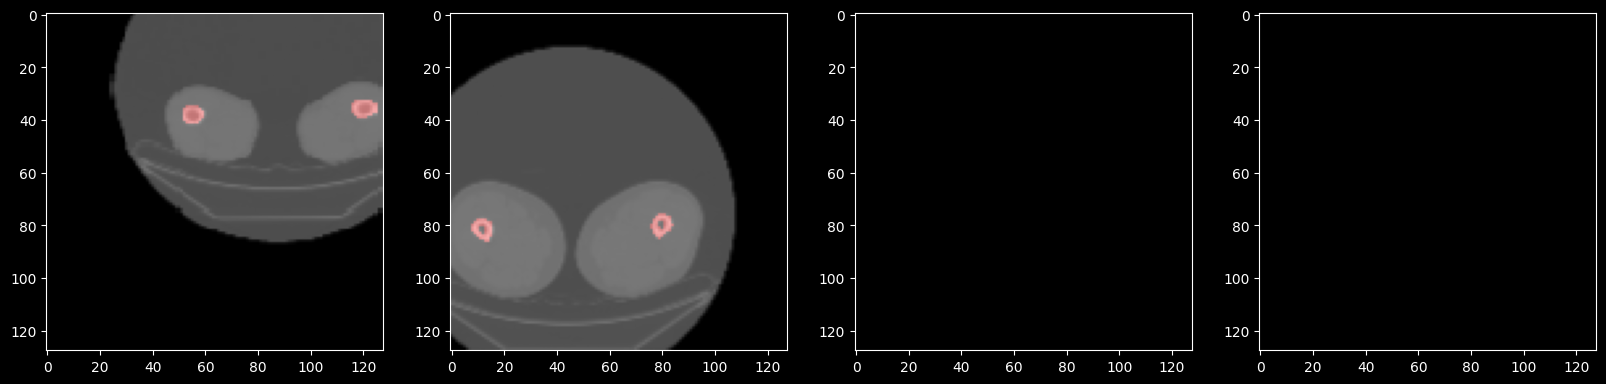

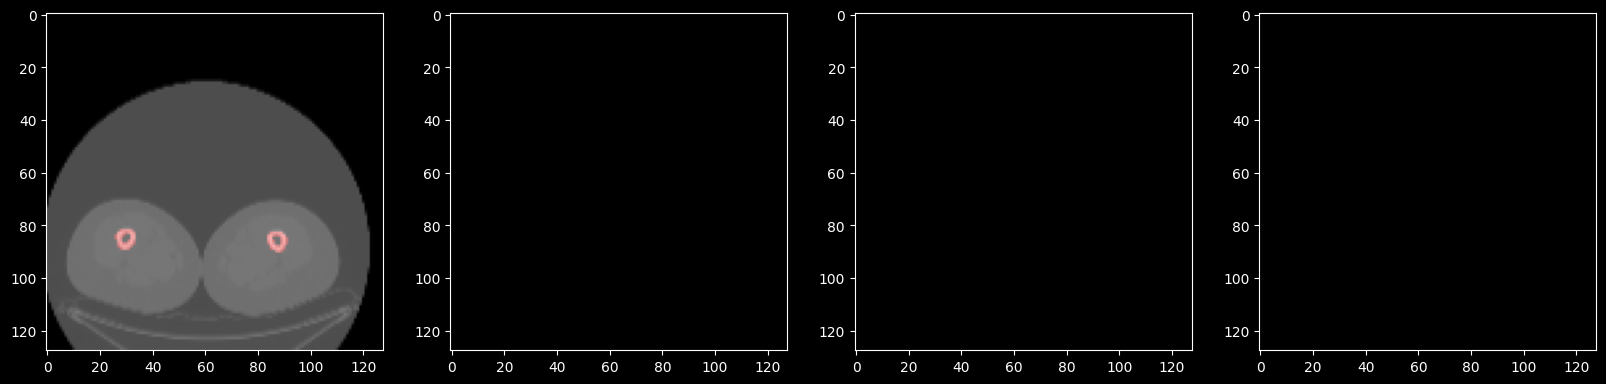

In [247]:
for i in range(2):
    f, axarr = plt.subplots(1,4)
    for p in range(4):
        idx = i*4+p
        img, mask = dataset_show_edit[idx]
        img = img[:, :, :, 50] 
        mask = mask[:, :, :, 50]
        # mask[0] = mask[0] + mask[3] + mask[6]
        # mask[1] = mask[1] + mask[4]
        # mask[2] = mask[2] + mask[5]
        # mask = mask[:3]
        img = img * 0.7 + mask * 0.3 
        axarr[p].imshow(img.transpose(0, 1).transpose(1, 2).squeeze())

In [265]:
def run(fold):
    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDatasetEdit(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDatasetEdit(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    device = torch.device("cpu")  # Set the device to CPU
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer)
        valid_loss, metric = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    # torch.cuda.empty_cache()
    torch.cpu.empty_cache()
    gc.collect()

In [266]:
run(0)

40 10
Tue Jul 11 16:20:45 2023 Epoch: 1


  0%|          | 0/10 [00:00<?, ?it/s]

Slices count: 841
Mask Slices count: 841


C:\Users\rache\AppData\Local\Temp\ipykernel_39740\3609588891.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()


torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])
Slices count: 585
Mask Slices count: 583
torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])
Slices count: 1057
Mask Slices count: 1057
torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])
Slices count: 505
Mask Slices count: 505
torch.Size([3, 128, 128, 1202])
torch.Size([3, 128, 128, 1202])


d:\Deep_Learning_for_3D_Image_Segmentation\myenv\lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
  0%|          | 0/10 [06:09<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 152 but got size 151 for tensor number 1 in the list.